# Linear Regression Analysis Flow

## 1. Get the dataset and variables

In [1]:
import pandas as pd

def read_data(dataset_name, x_col, y_col):
    data = pd.read_csv(dataset_name)
    X = data[x_col]
    Y = data[y_col]
    
    return data, X, Y

In [2]:
dataset_name = 'data/gdp_vs_happiness.csv'
x_col, y_col = 'GDP per capita', 'Score'

data, X, Y = read_data(dataset_name, x_col, y_col)

## 2. Create Linear Regression model

In [3]:
import statsmodels.api as sm

def create_lin_reg_model(X, Y):
    X = sm.add_constant(X) # to include intercept
    lin_reg = sm.OLS(Y, X).fit()
    
    return lin_reg

In [4]:
lin_reg = create_lin_reg_model(X, Y)

### 2.1 Get initial results

Includes slope coefficient, intercept coefficient, and RMSE (root mean squared error - average residual size)

In [5]:
from statsmodels.tools.eval_measures import rmse

def get_lin_reg_results(model):
    
    print('Results for Linear Regression')
    
    print('Intercept Coefficient: ', model.params[0])
    print('Slope Coefficient: ', model.params[1])
    
    preds = model.predict(sm.add_constant(X))
    print('RMSE: ', rmse(Y, preds))

In [6]:
get_lin_reg_results(lin_reg)

Results for Linear Regression
Intercept Coefficient:  3.3993451782924162
Slope Coefficient:  2.218148001008356
RMSE:  0.6746826955928508


## 3. Get Correlation Coefficient

Using Pearson's coefficient

In [7]:
from scipy.stats import pearsonr

def get_correlation(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr

In [8]:
get_correlation(X, Y)

0.7938828678781276

## 4. Identify Outliers

Using studentized residuals. Any points whose studentized residuals is over 3 will be considered an outlier.

In [9]:
def get_outliers(model, data, threshold=3):
    data_copy = data.copy()
    data_copy['Stu_residual'] = model.get_influence().resid_studentized_internal
    return data_copy[abs(data_copy['Stu_residual']) > threshold]

In [10]:
outliers = get_outliers(lin_reg, data)
outliers

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Stu_residual
147,148,Botswana,3.488,1.041,1.145,0.538,0.455,0.025,0.1,-3.281689


## 5. See how linear regression changes if outliers are excluded (is it influential?)

This is not important for the outlier analysis, but let's see if the outliers affect the linear regression dramatically.

In [15]:
data_no_outliers = data.drop(outliers.index)
lin_reg_no_outliers = create_lin_reg_model(data_no_outliers[x_col], data_no_outliers[y_col])
get_lin_reg_results(lin_reg_no_outliers)

Results for Linear Regression
Intercept Coefficient:  3.4025025006593452
Slope Coefficient:  2.230498369014435
RMSE:  0.6748528142161883


Turns out that it actually drops the quality of the model based on the RSME.

## 6. Plot final visualization

In [17]:
import matplotlib.pyplot as plt

def plot_scatter(data, x_col, y_col, i_col=None, outlier=False):
    if outlier:
        
        for i in range(len(data)):
            point = outliers.iloc[i,:]
            plt.plot(point[x_col], point[y_col], 'rx')
            plt.text(x=point[x_col] + 0.02, y=point[y_col], s=point[i_col])
    else:
        plt.scatter(data[x_col], data[y_col], s=3)
        
        
def plot_trend(X, model):
    preds = model.predict(sm.add_constant(X))
    plt.plot(X, preds)

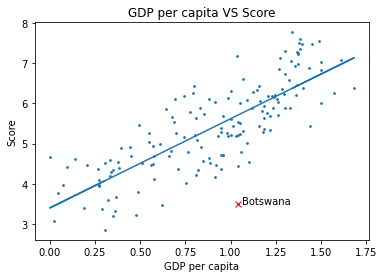

In [18]:
plt.close()
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(x_col + ' VS ' + y_col)
plot_scatter(data, x_col, y_col)
plot_scatter(outliers, x_col, y_col, i_col='Country or region', outlier=True)
plot_trend(X, lin_reg)